# First deep learning approach: Detection by classification in sliding window fashion. 

We first mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path
import os
repo_path = Path.cwd()/'drive/MyDrive/calcification_detection/calc-det/notebooks/'
os.chdir(str(repo_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Move the files to the localhost to run faster

In [ ]:
# !mkdir '/home/INbreast Release 1.0/'
# !mkdir '/home/INbreast Release 1.0/AllPNGs/'
# !mkdir '/home/INbreast Release 1.0/AllMasks/'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/calc-det/data/INbreast Release 1.0/AllPNGs/full_imgs' '/home/INbreast Release 1.0/AllPNGs/'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/calc-det/data/INbreast Release 1.0/images_metadata.csv' '/home/INbreast Release 1.0/images_metadata.csv'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/calc-det/data/INbreast Release 1.0/rois_metadata.csv' '/home/INbreast Release 1.0/rois_metadata.csv'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/calc-det/data/INbreast Release 1.0/AllMasks/full_imgs' '/home/INbreast Release 1.0/AllMasks/'

# !mkdir '/home/deepl_runs'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/data/deepl_runs/16_net2_07' '/home/deepl_runs/'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/data/deepl_runs/32_net2_05' '/home/deepl_runs/'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/data/deepl_runs/64_net2_03' '/home/deepl_runs/'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/data/deepl_runs/resnet50_05' '/home/deepl_runs/'

# !pip install transformers

Generate the database of images in the validation set

In [2]:
from pathlib import Path
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))
from database.dataset import INBreast_Dataset

db = INBreast_Dataset(
    imgpath = Path('/home/INbreast Release 1.0/AllPNGs'),
    mask_path = Path('/home/INbreast Release 1.0/AllMasks'),
    dfpath = Path('/home/INbreast Release 1.0'),
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15
  )

### Create a function to get the detection over a complete dataset

In [3]:
import pickle
import time
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

from metrics.metrics_utils import get_froc_df_of_img, get_tp_fp_fn_center_patch_criteria

def get_froc_dataframe_from_set(db, detector, results_path, store_time = False, multiscale=False):
    # get normal images
    normal_imgs_ids = db.get_free_of_selected_lesions_imgs_ids()

    # define paths to store intermediate results
    results_path = Path(results_path)
    frocs_df_path = results_path / 'froc_df.csv'
    times_path = results_path / 'times.p'
    froc_dfs = []
    times = []

    # get the detections for each image in the database
    for idx in range(len(db)):
        # get sample
        db_sample = db[idx]
        image = db_sample['img']
        image_id = db_sample['img_id']
        image_mask = db_sample['lesion_mask']

        # set sample's storing paths
        results_path_img = results_path / f'{image_id}'
        results_path_img.mkdir(exist_ok=True, parents=True)
        raw_saliency_path = results_path_img / f'{image_id}_raw_sm.tiff'
        final_saliency_path = results_path_img / f'{image_id}_final_sm.tiff'
        froc_df_path = results_path_img / f'{image_id}_froc_df.csv'
        
        # get detections:
        start = time.time()
        if multiscale:
            detections = detector.detect(image, image_id, final_saliency_path, store=True)
        else:
            detections = detector.detect(image, raw_saliency_path, final_saliency_path, store=True)
        times.append(time.time()-start)

        # reformat detections
        detections_centers = detections[:, 0:2].astype(int)
        detections_scores = detections[:, -1].reshape(-1, 1)
        detections_radius = np.ones(detections_scores.shape) * 7
        # retain the centers and scores:
        candidates = np.concatenate(
            [detections_centers, detections_radius, detections_scores], axis = 1)

        # compare with labels
        tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
            candidates, image_mask, None, 14, use_euclidean_dist=True, scores_passed=True)
        candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

        # generate standard dataframe
        froc_df = get_froc_df_of_img(
            candidates, fn, candidates['score'], image_id, (image_id in normal_imgs_ids))
        
        # store and acumulate standard dataframe
        froc_df.to_csv(froc_df_path)
        froc_dfs.append(froc_df)
    
    # store full
    froc_dfs = pd.concat(froc_dfs, ignore_index=True)
    froc_dfs.to_csv(frocs_df_path)
    if store_time:
        with open(times_path, 'wb') as f:
            pickle.dump(times, f)
    return froc_dfs

In [7]:
from deep_learning.dl_utils import get_model_from_checkpoint
from deep_learning.models.class_based_detector import ClassificationBasedDetector, MultiScaleClassificationBasedDetector
from general_utils.plots import plot_froc, plot_several_frocs, add_detections_overlay
from metrics.metrics import froc_curve
from metrics.metrics_utils import best_th_froc_curve
import general_utils.utils as utils
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None 

### Best model using 224x224 patches (Resnet50 - resnet50_02)

In [ ]:
# model
model_path = '/home/deepl_runs/resnet50_05/resnet50_05.pt'
model_ckpt = torch.load(model_path)
model = get_model_from_checkpoint(model_ckpt)
model.eval()

# detector instatiation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
detector = ClassificationBasedDetector(
    model,
    threshold=0,
    pred_kind='score',
    norm_kind='avg',
    post_proc=True,
    k_size=17,
    patch_size=224,
    stride=12,
    min_breast_fraction_patch=0.7,
    batch_size=720,
    device=device,
    nms=True,
    iou_threshold=1)

results_path = Path('/content/drive/MyDrive/calcification_detection/detections_dl/224_resnet50_05')
froc_dfs_224 = get_froc_dataframe_from_set(db, detector, results_path, store_time = False)

Distribution of labels among detections

In [ ]:
froc_dfs_224.label.value_counts()

FP    25091
FN      559
TP       74
Name: label, dtype: int64

Threshold: 0.7274762988090515, TPR: 0.053712480252764615, FPR: 0.3870967741935484


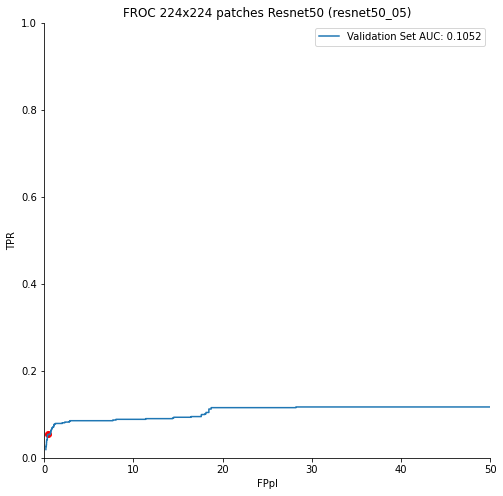

In [ ]:
sens, avgs_fp_per_image, thresholds = froc_curve(froc_dfs_224, non_max_supression=True, cut_on_50fpi=True)
th, tpr, fpr = best_th_froc_curve(np.asarray(sens), np.asarray(avgs_fp_per_image), np.asarray(thresholds))
print(f'Threshold: {th}, TPR: {tpr}, FPR: {fpr}')
sens.append(sens[-1])
avgs_fp_per_image.append(50)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(fpr, tpr, label='selected point', c='r')
plot_froc(avgs_fp_per_image, sens, label='Validation Set', title='FROC 224x224 patches Resnet50 (resnet50_05)', ax=ax)

### Best model using 64x64 patches (ResnetBased - 64_net2_03)

In [ ]:
# !find /content/drive/MyDrive/calcification_detection/detections_dl/64_net2_03 -name '*final_sm.tiff' -exec rm {} \;

In [ ]:
# model
model_path = '/home/deepl_runs/64_net2_03/64_net2_03_auroc.pt'
model_ckpt = torch.load(model_path)
model = get_model_from_checkpoint(model_ckpt)
model.eval()

# detector instatiation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
detector = ClassificationBasedDetector(
    model,
    threshold=0,
    pred_kind='score',
    norm_kind='avg',
    post_proc=True,
    k_size=13,
    patch_size=64,
    stride=12,
    min_breast_fraction_patch=0.7,
    batch_size=512,
    device=device,
    nms=True,
    iou_threshold=1)

results_path = Path('/content/drive/MyDrive/calcification_detection/detections_dl/64_net2_03')
froc_dfs_64 = get_froc_dataframe_from_set(db, detector, results_path, store_time = False)

In [ ]:
froc_dfs_64.label.value_counts()

FP    116182
FN       368
TP       357
Name: label, dtype: int64

Threshold: 0.31617915630340576, TPR: 0.2015873015873016, FPR: 6.129032258064516


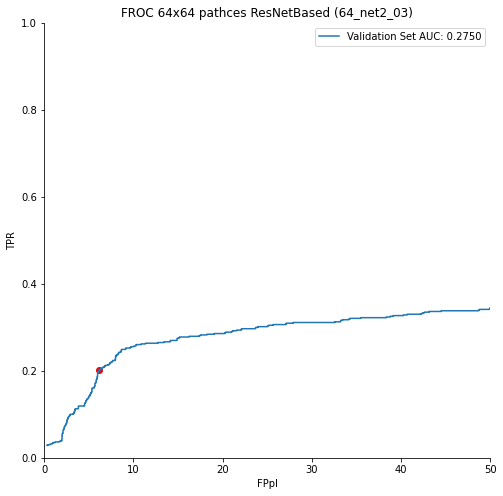

In [ ]:
sens, avgs_fp_per_image, thresholds = froc_curve(froc_dfs_64, non_max_supression=True, cut_on_50fpi=True)
th, tpr, fpr = best_th_froc_curve(np.asarray(sens), np.asarray(avgs_fp_per_image), np.asarray(thresholds))
print(f'Threshold: {th}, TPR: {tpr}, FPR: {fpr}')

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(fpr, tpr, label='selected point', c='r')
plot_froc(avgs_fp_per_image, sens, label='Validation Set', title='FROC 64x64 pathces ResNetBased (64_net2_03)', ax=ax)

### Best model using 32x32 patches (ResnetBased - 32_net2_05)


In [ ]:
# !find /content/drive/MyDrive/calcification_detection/detections_dl/32_net2_05 -name '*final_sm.tiff' -exec rm {} \;

In [ ]:
# model
model_path = '/home/deepl_runs/32_net2_05/32_net2_05_auroc.pt'
model_ckpt = torch.load(model_path)
model = get_model_from_checkpoint(model_ckpt)
model.eval()

# detector instatiation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
detector = ClassificationBasedDetector(
    model,
    threshold=0,
    pred_kind='score',
    norm_kind='avg',
    post_proc=True,
    k_size=17,
    patch_size=32,
    stride=8,
    min_breast_fraction_patch=0.7,
    batch_size=1024,
    device=device,
    nms=True,
    iou_threshold=1)

results_path = Path('/content/drive/MyDrive/calcification_detection/detections_dl/32_net2_05')
froc_dfs_32 = get_froc_dataframe_from_set(db, detector, results_path, store_time = False)

In [ ]:
froc_dfs_32.label.value_counts()

FP    91721
FN      326
TP      299
Name: label, dtype: int64

Threshold: 0.2795366644859314, TPR: 0.368, FPR: 4.290322580645161


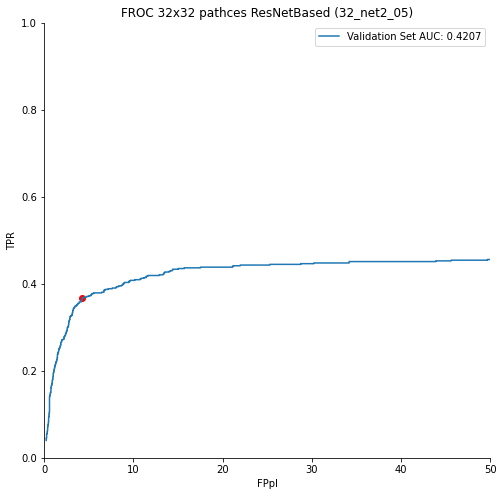

In [ ]:
sens, avgs_fp_per_image, thresholds = froc_curve(froc_dfs_32, non_max_supression=True, cut_on_50fpi=True)
th, tpr, fpr = best_th_froc_curve(np.asarray(sens), np.asarray(avgs_fp_per_image), np.asarray(thresholds))
print(f'Threshold: {th}, TPR: {tpr}, FPR: {fpr}')

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(fpr, tpr, label='selected point', c='r')
plot_froc(avgs_fp_per_image, sens, label='Validation Set', title='FROC 32x32 pathces ResNetBased (32_net2_05)', ax=ax)

### Best model using 16x16 patches (ResnetBased - 16_net2_07)

In [ ]:
# !find /content/drive/MyDrive/calcification_detection/detections_dl/16_net2_07 -name '*final_sm.tiff' -exec rm {} \;

In [ ]:
# model
model_path = '/home/deepl_runs/16_net2_07/16_net2_07_auroc.pt'
model_ckpt = torch.load(model_path)
model = get_model_from_checkpoint(model_ckpt)
model.eval()

# detector instatiation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
detector = ClassificationBasedDetector(
    model,
    threshold=0,
    pred_kind='score',
    norm_kind='avg',
    post_proc=True,
    k_size=9,
    patch_size=16,
    stride=8,
    min_breast_fraction_patch=0.7,
    batch_size=2048,
    device=device,
    nms=True,
    iou_threshold=1)

results_path = Path('/content/drive/MyDrive/calcification_detection/detections_dl/16_net2_07')
froc_dfs_16 = get_froc_dataframe_from_set(db, detector, results_path, store_time = False)

In [ ]:
froc_dfs_16.label.value_counts()

FP    224715
TP       423
FN       211
Name: label, dtype: int64

Threshold: 0.36629703640937805, TPR: 0.42630744849445323, FPR: 6.612903225806452


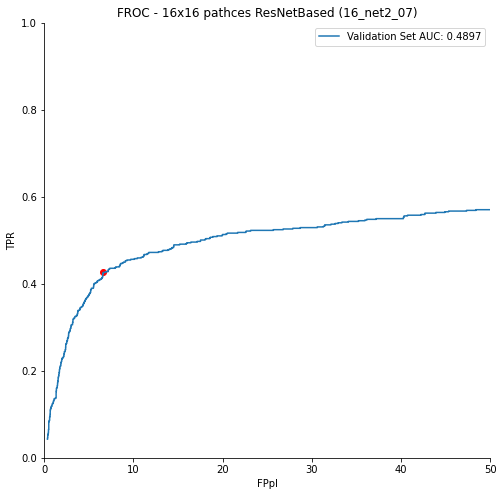

In [ ]:
sens, avgs_fp_per_image, thresholds = froc_curve(froc_dfs_16, non_max_supression=True, cut_on_50fpi=True)
th, tpr, fpr = best_th_froc_curve(np.asarray(sens), np.asarray(avgs_fp_per_image), np.asarray(thresholds))
print(f'Threshold: {th}, TPR: {tpr}, FPR: {fpr}')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(fpr, tpr, label='selected point', c='r')
plot_froc(avgs_fp_per_image, sens, label='Validation Set', title='FROC - 16x16 pathces ResNetBased (16_net2_07)', ax=ax)

# Multiscale Approach
## All scales and mean combination


In [ ]:
detector = MultiScaleClassificationBasedDetector(
    scales=[16, 32, 64],
    bbox_size=14,
    threshold=0,
    iou_threshold=1
)

results_path = Path('/content/drive/MyDrive/calcification_detection/detections_dl/multiscale_16_32_64')
froc_dfs_16_32_64 = get_froc_dataframe_from_set(db, detector, results_path, store_time = False, multiscale=True)


In [ ]:
froc_dfs_16_32_64.label.value_counts()

FP    142201
TP       380
FN       246
Name: label, dtype: int64

Threshold: 0.2318960539996624, TPR: 0.4432, FPR: 4.290322580645161


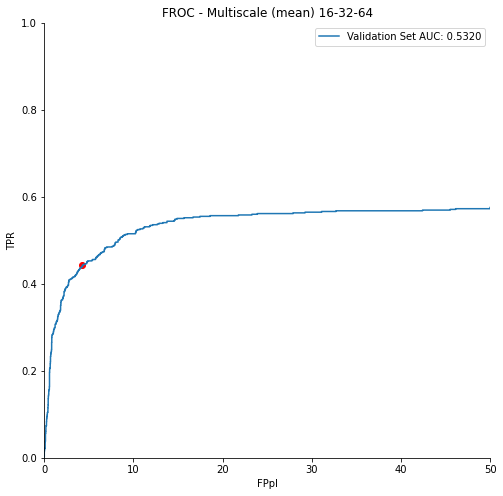

In [ ]:
sens, avgs_fp_per_image, thresholds = froc_curve(froc_dfs_16_32_64, non_max_supression=True, cut_on_50fpi=True)
th, tpr, fpr = best_th_froc_curve(np.asarray(sens), np.asarray(avgs_fp_per_image), np.asarray(thresholds))
print(f'Threshold: {th}, TPR: {tpr}, FPR: {fpr}')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(fpr, tpr, label='selected point', c='r')
plot_froc(avgs_fp_per_image, sens, label='Validation Set', title='FROC - Multiscale (mean) 16-32-64', ax=ax)

### 16 and 32 scales and mean combination


In [ ]:
detector = MultiScaleClassificationBasedDetector(
    scales=[16, 32],
    bbox_size=14,
    threshold=0,
    iou_threshold=1
)

results_path = Path('/content/drive/MyDrive/calcification_detection/detections_dl/multiscale_16_32')
froc_dfs_16_32 = get_froc_dataframe_from_set(db, detector, results_path, store_time = False, multiscale=True)


In [ ]:
froc_dfs_16_32.label.value_counts()

FP    146207
TP       392
FN       233
Name: label, dtype: int64

Threshold: 0.2878517508506775, TPR: 0.4448, FPR: 5.274193548387097


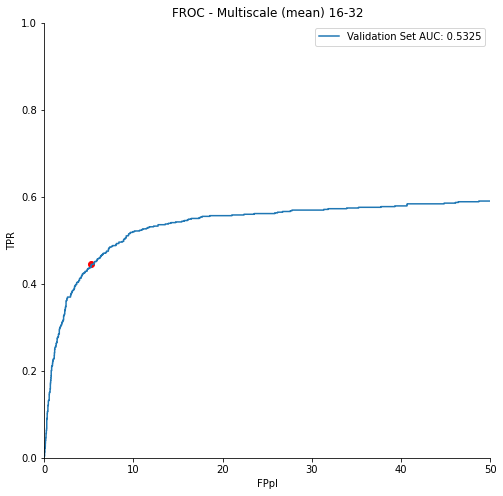

In [ ]:
sens, avgs_fp_per_image, thresholds = froc_curve(froc_dfs_16_32, non_max_supression=True, cut_on_50fpi=True)
th, tpr, fpr = best_th_froc_curve(np.asarray(sens), np.asarray(avgs_fp_per_image), np.asarray(thresholds))
print(f'Threshold: {th}, TPR: {tpr}, FPR: {fpr}')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(fpr, tpr, label='selected point', c='r')
plot_froc(avgs_fp_per_image, sens, label='Validation Set', title='FROC - Multiscale (mean) 16-32', ax=ax)

### 16 and 32 scales and max combination

In [ ]:
detector = MultiScaleClassificationBasedDetector(
    scales=[16, 32],
    bbox_size=14,
    threshold=0,
    iou_threshold=1,
    merge_type='max'
)

results_path = Path('/content/drive/MyDrive/calcification_detection/detections_dl/multiscale_16_32_max')
froc_dfs_16_32_max = get_froc_dataframe_from_set(db, detector, results_path, store_time = False, multiscale=True)


In [ ]:
froc_dfs_16_32_max.label.value_counts()

FP    154208
TP       383
FN       265
Name: label, dtype: int64

Threshold: 0.2878517508506775, TPR: 0.4448, FPR: 5.274193548387097


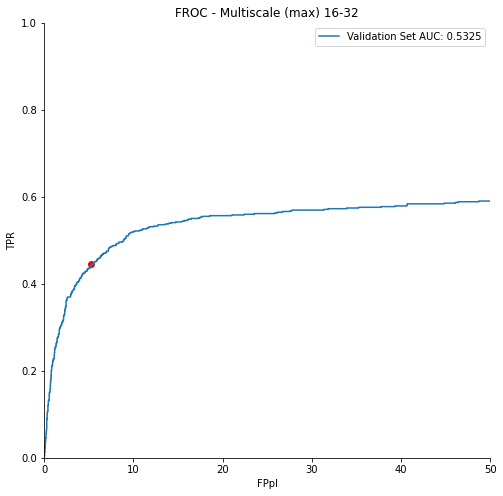

In [ ]:
sens, avgs_fp_per_image, thresholds = froc_curve(froc_dfs_16_32, non_max_supression=True, cut_on_50fpi=True)
th, tpr, fpr = best_th_froc_curve(np.asarray(sens), np.asarray(avgs_fp_per_image), np.asarray(thresholds))
print(f'Threshold: {th}, TPR: {tpr}, FPR: {fpr}')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(fpr, tpr, label='selected point', c='r')
plot_froc(avgs_fp_per_image, sens, label='Validation Set', title='FROC - Multiscale (max) 16-32', ax=ax)

## Comparison of FROCS

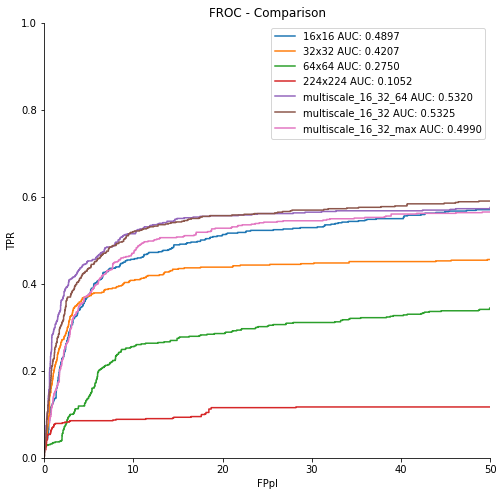

In [ ]:
base_path = '/content/drive/MyDrive/calcification_detection/detections_dl'
models = ['16_net2_07', '32_net2_05', '64_net2_03', '224_resnet50_05',
          'multiscale_16_32_64','multiscale_16_32','multiscale_16_32_max']
frocs = {}
for model in tqdm(models):
    path = Path(base_path)/model
    froc_df = pd.read_csv(path/'froc_df.csv')
    tprs, fpis, ths = froc_curve(froc_df, cut_on_50fpi=True)
    if '224' in model:
        tprs.append(tprs[-1])
        fpis.append(50)
    name = model.split('_')[0]
    name = model if (name == 'multiscale') else f'{name}x{name}'
    frocs[name] = {'tprs': tprs, 'fpis': fpis, 'ths': ths}

plot_several_frocs(frocs, title='FROC - Comparison', cut_on_50fpi=True)

## Comparison of Time

100%|██████████| 4/4 [00:00<00:00, 675.68it/s]


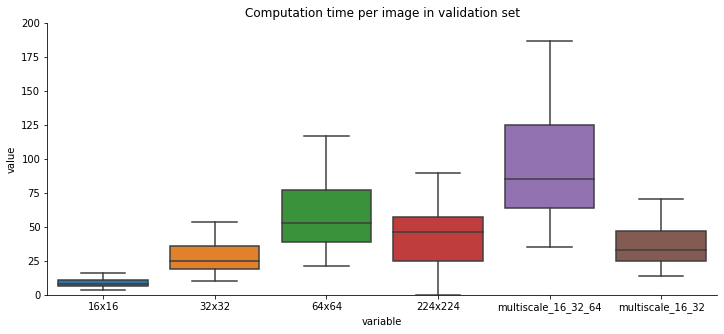

In [ ]:
base_path = '/content/drive/MyDrive/calcification_detection/detections_dl'
models = ['16_net2_07', '32_net2_05', '64_net2_03', '224_resnet50_05']
times = {}
for model in tqdm(models):
    path = Path(base_path)/model/'times.p'
    with open(path, 'rb') as f:
        time = pickle.load(f)
    name = model.split('_')[0]
    name = f'{name}x{name}'
    times[name] = time
times = pd.DataFrame(times)
times['multiscale_16_32_64'] = times['16x16'] + times['32x32'] + times['64x64']
times['multiscale_16_32'] = times['16x16'] + times['32x32']
plt.figure(figsize=(12,5))
plt.title('Computation time per image in validation set')
plt.ylabel('Time [s]')
plt.ylim([0, 200])
plt.xlabel('Model')
sns.boxplot(x="variable", y="value", data=pd.melt(times))
sns.despine()

### Comparison of saliency maps and detections in 16x16 and multiscale models

100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


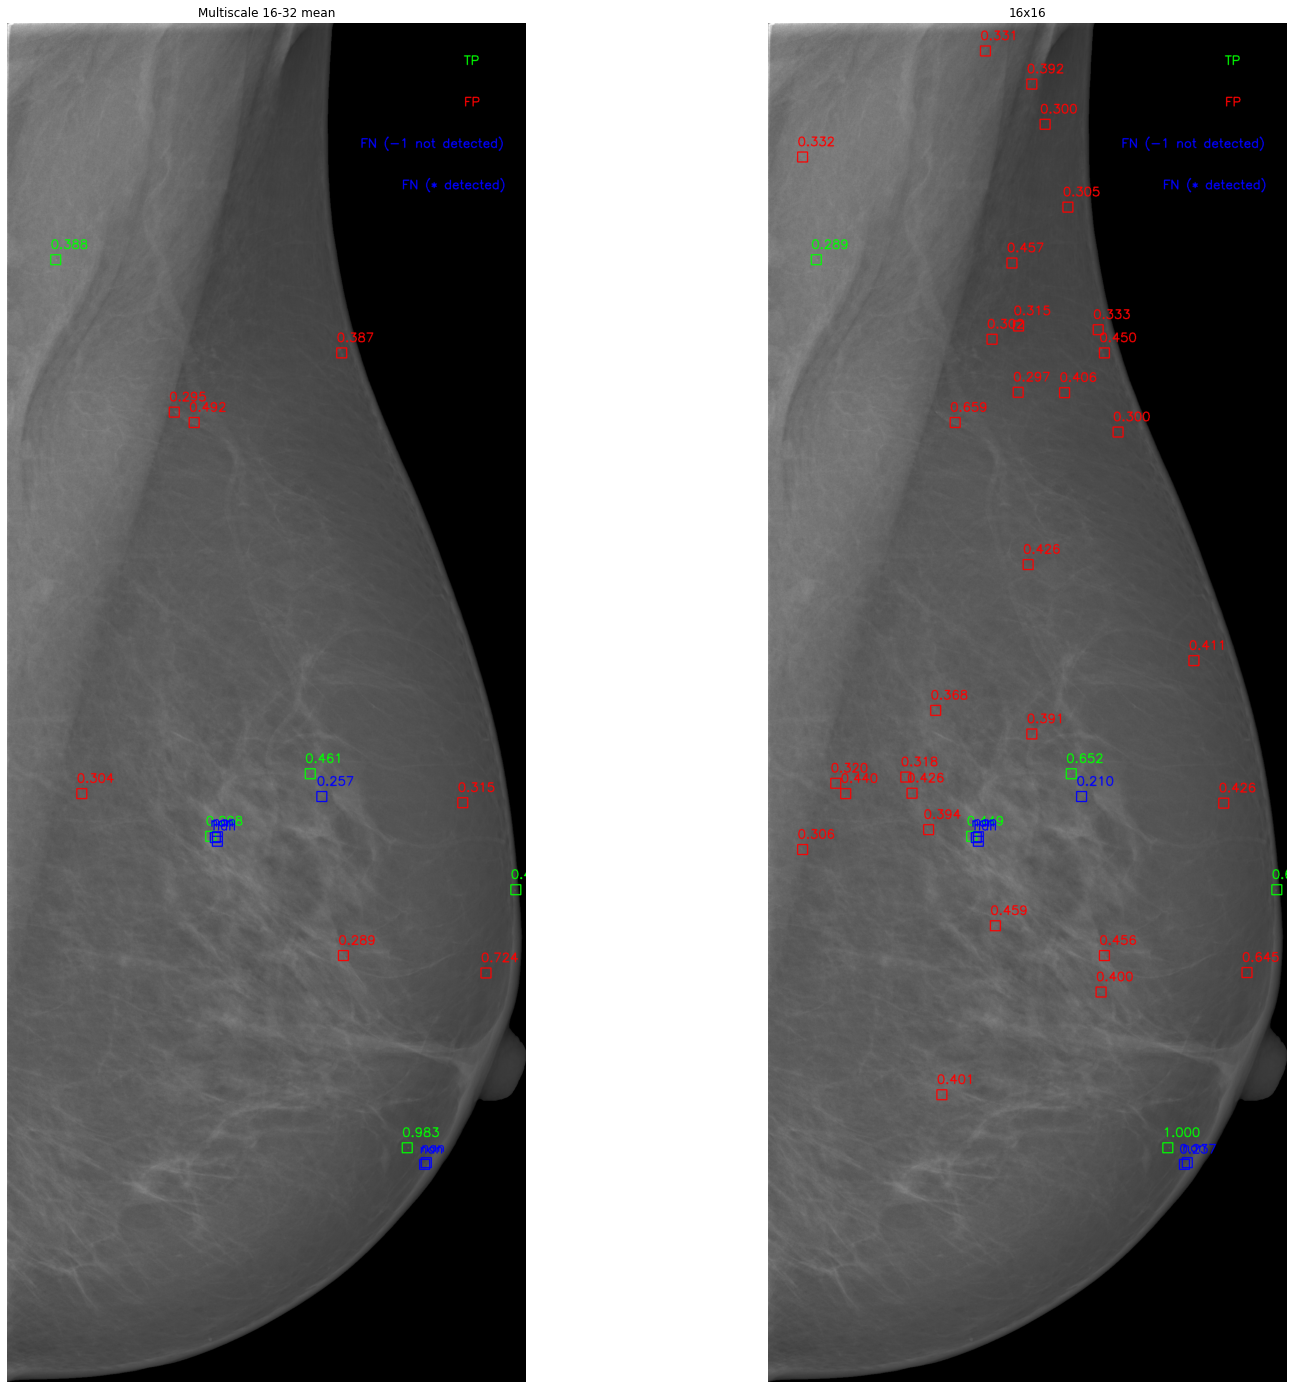

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model
model_path = '/home/deepl_runs/16_net2_07/16_net2_07_auroc.pt'
model_ckpt = torch.load(model_path)
model = get_model_from_checkpoint(model_ckpt)
model.eval()

# detectors instatiation
detector_16 = ClassificationBasedDetector(model, threshold=0, pred_kind='score',
    norm_kind='avg', post_proc=True, k_size=9, patch_size=16, stride=8, min_breast_fraction_patch=0.7,
    batch_size=2048, device=device, nms=True, iou_threshold=1)
detector_ms = MultiScaleClassificationBasedDetector(
    scales=[16, 32], bbox_size=14, threshold=0, iou_threshold=1)

# get image
idx = 20
db_sample = db[idx]
image = db_sample['img']
image_id = db_sample['img_id']
image_mask = db_sample['lesion_mask']

# get detections
detections_ms = detector_ms.detect(image, image_id, store=False)
detections_16 = detector_16.detect(image, store=False)

# reformat detections
detections_ms_centers = detections_ms[:, 0:2].astype(int)
detections_ms_scores = detections_ms[:, -1].reshape(-1, 1)
detections_ms_radius = np.ones(detections_ms_scores.shape) * 7
detections_ms = np.concatenate(
    [detections_ms_centers, detections_ms_radius, detections_ms_scores], axis = 1)

detections_16_centers = detections_16[:, 0:2].astype(int)
detections_16_scores = detections_16[:, -1].reshape(-1, 1)
detections_16_radius = np.ones(detections_16_scores.shape) * 7
detections_16 = np.concatenate(
    [detections_16_centers, detections_16_radius, detections_16_scores], axis = 1)

# Generate the images
image_ms = add_detections_overlay(
    image, detections_ms, image_mask, conf_thr=0.28785, k=10, need_labeling = True)
image_ms = cv2.cvtColor(image_ms, cv2.COLOR_BGR2RGB)
image_16 = add_detections_overlay(
    image, detections_16, image_mask, conf_thr=0.28785, k=10, need_labeling = True)
image_16 = cv2.cvtColor(image_16, cv2.COLOR_BGR2RGB)

# plot
fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].set_title('Multiscale 16-32 mean')
ax[0].imshow(image_ms)
ax[0].axis('off')
ax[1].set_title('16x16')
ax[1].imshow(image_16)
ax[1].axis('off')
plt.show()

# Example on how to store the detections as dcm image

In [9]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
idx = 20
db_sample = db[idx]
image = db_sample['img']
image_id = db_sample['img_id']
image_mask = db_sample['lesion_mask']

fields = ['img_id', 'case_id', 'side', 'view', 'breast_bbox']
fields = db.img_df.loc[db.img_df.img_id == image_id, fields].values[0]
view = 'ML' if fields[3] == 'MLO' else fields[3]
dcm_img_name = f'{fields[0]}_{fields[1]}_MG_{fields[2]}_{view}_ANON.dcm'
dcm_path = repo_path.parent/'data/INbreast Release 1.0/AllDICOMs/'
original_dcm_filepath = dcm_path/dcm_img_name
breast_bbox = fields[-1]

output_filepath = repo_path.parent.parent / 'example.dcm'

detections_ms_df = pd.DataFrame(detections_ms, columns=['x', 'y', 'radius', 'score'])
utils.store_as_dcm(
    image, detections_ms_df, original_dcm_filepath, output_filepath, breast_bbox)
